In [114]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin

## 2. Define SafeSVD Class

In [115]:
class SafeSVD(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.svd = None

    def fit(self, X, y=None):
        if X.shape[1] > 1:  # Only apply SVD if >1 features
            n_comp = min(self.n_components, X.shape[1]-1)
            self.svd = TruncatedSVD(n_components=n_comp, random_state=42)
            self.svd.fit(X, y)
        return self

    def transform(self, X):
        if self.svd:
            return self.svd.transform(X)
        return X  # If only 1 feature, skip SVD

## 1) Data load + quick EDA

In [66]:
df = pd.read_csv("/content/drive/MyDrive/Project /Intrenship/DataSets/loan_data.csv")   # apna CSV filename yahan daalain

In [67]:
print(df.shape)

(24000, 7)


In [68]:
df.head()

,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,I need a loan to pay for an international vaca...,26556,581,8314,79.26,employed,Rejected
1,I want to make home improvements like installi...,197392,389,111604,22.14,employed,Rejected
2,"I need a loan for home renovation, including a...",44561,523,34118,45.44,employed,Rejected
3,I need funds to buy new furniture and applianc...,190363,729,118757,10.22,unemployed,Rejected
4,I need a loan to start a small business.,61853,732,19210,44.13,employed,Approved


In [69]:
df.tail()

,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
23995,I need funds to pay for my daughter's college ...,195242,817,16403,24.32,employed,Approved
23996,I need financial assistance to launch my own Y...,150246,729,101572,9.97,employed,Rejected
23997,I need money to open a small bookstore and café.,64571,650,30533,57.35,employed,Rejected
23998,I want to buy a car for my rideshare business ...,115825,418,89837,10.37,unemployed,Rejected
23999,I need financial help to cover maternity and d...,180440,769,15259,15.06,employed,Approved


In [70]:
print("Null counts:\n", df.isnull().sum())

Null counts:
 Text                 0
Income               0
Credit_Score         0
Loan_Amount          0
DTI_Ratio            0
Employment_Status    0
Approval             0
dtype: int64


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Text               24000 non-null  object 
 1   Income             24000 non-null  int64  
 2   Credit_Score       24000 non-null  int64  
 3   Loan_Amount        24000 non-null  int64  
 4   DTI_Ratio          24000 non-null  float64
 5   Employment_Status  24000 non-null  object 
 6   Approval           24000 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.3+ MB


In [72]:
df.Approval.value_counts()

,count
Approval,
Rejected,20067
Approved,3933


# DATA VISUALLIZATION

## Countplot (grouped)

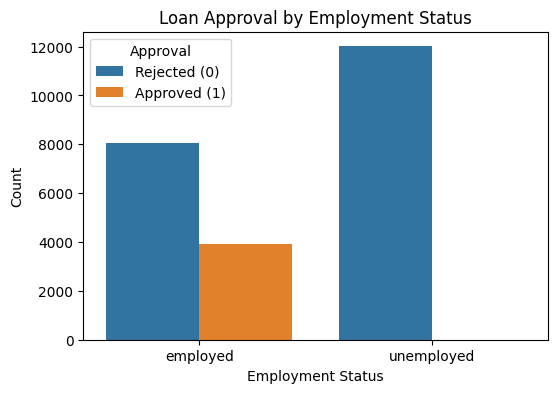

In [117]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Employment_Status", hue="Approval")
plt.title("Loan Approval by Employment Status")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.legend(title="Approval", labels=["Rejected (0)", "Approved (1)"])
plt.show()


## Percentage plot (optional – more clear)

/tmp/ipython-input-2021248989.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Approval"] = df["Approval"].replace({"Rejected" : 0, "Approved" : 1}).astype(int)


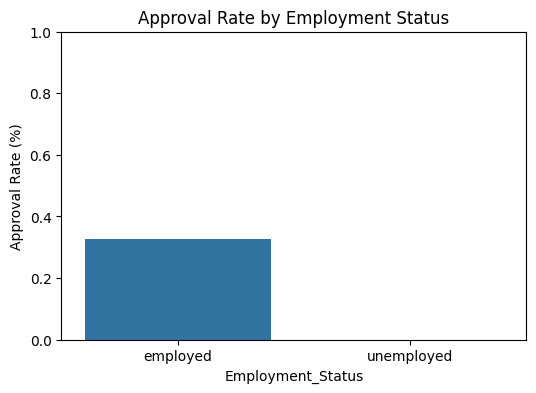

In [74]:
df["Approval"] = df["Approval"].replace({"Rejected" : 0, "Approved" : 1}).astype(int)
approval_rate = df.groupby("Employment_Status")["Approval"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=approval_rate, x="Employment_Status", y="Approval")
plt.title("Approval Rate by Employment Status")
plt.ylabel("Approval Rate (%)")
plt.ylim(0,1)  # 0 to 100% scale
plt.show()

## Boxplot (distribution compare)

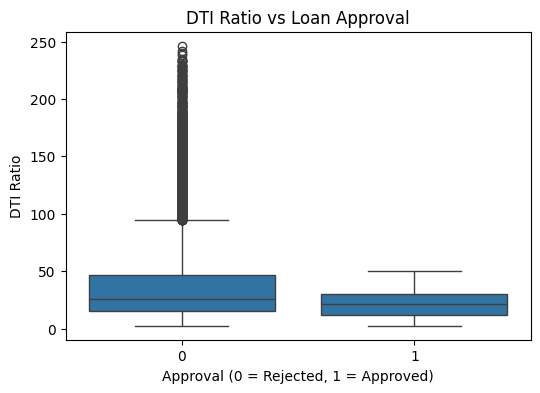

In [118]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Approval", y="DTI_Ratio")
plt.title("DTI Ratio vs Loan Approval")
plt.xlabel("Approval (0 = Rejected, 1 = Approved)")
plt.ylabel("DTI Ratio")
plt.show()

## Histogram / KDE plot (distribution overlap)

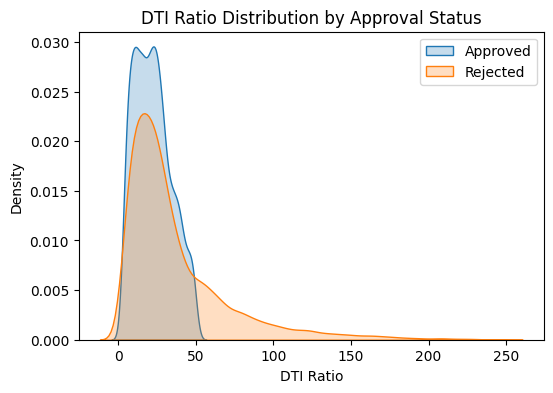

In [119]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df[df["Approval"]==1]["DTI_Ratio"], label="Approved", shade=True)
sns.kdeplot(data=df[df["Approval"]==0]["DTI_Ratio"], label="Rejected", shade=True)
plt.title("DTI Ratio Distribution by Approval Status")
plt.xlabel("DTI Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()

## Boxplot — Distribution of loan amount by approval

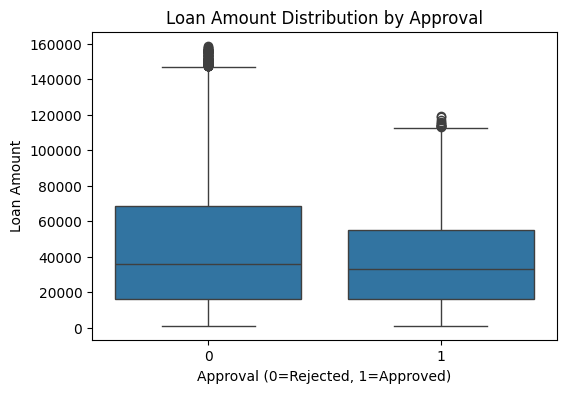

In [120]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Approval", y="Loan_Amount")
plt.title("Loan Amount Distribution by Approval")
plt.xlabel("Approval (0=Rejected, 1=Approved)")
plt.ylabel("Loan Amount")
plt.show()

## Violinplot (same idea, more detailed distribution)

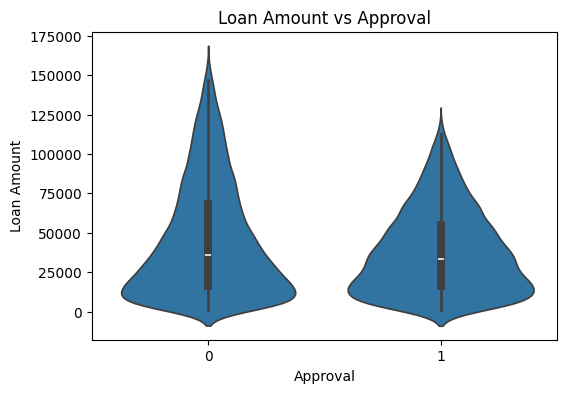

In [78]:
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="Approval", y="Loan_Amount")
plt.title("Loan Amount vs Approval")
plt.xlabel("Approval")
plt.ylabel("Loan Amount")
plt.show()

## Histogram / KDE — Compare distributions

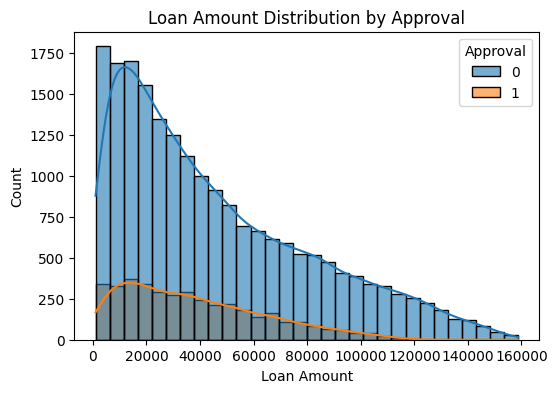

In [79]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Loan_Amount", hue="Approval", kde=True, bins=30, alpha=0.6)
plt.title("Loan Amount Distribution by Approval")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

## Credit_Score is categorical

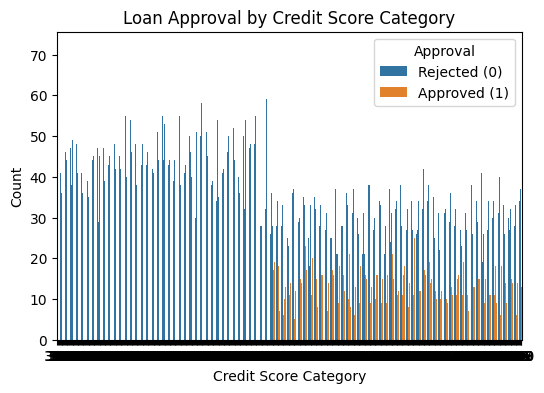

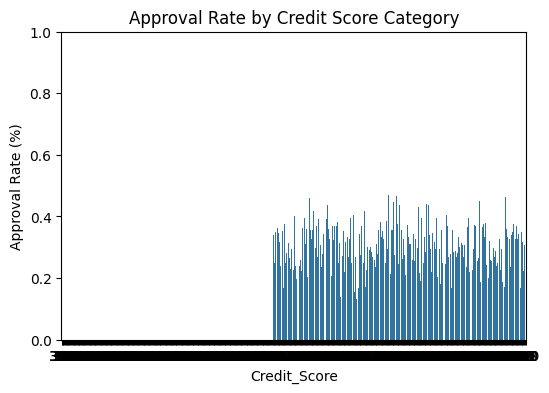

In [121]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Credit_Score", hue="Approval")
plt.title("Loan Approval by Credit Score Category")
plt.xlabel("Credit Score Category")
plt.ylabel("Count")
plt.legend(title="Approval", labels=["Rejected (0)", "Approved (1)"])
plt.show()

# Percentage approval per category
score_rate = df.groupby("Credit_Score")["Approval"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=score_rate, x="Credit_Score", y="Approval")
plt.title("Approval Rate by Credit Score Category")
plt.ylabel("Approval Rate (%)")
plt.ylim(0,1)
plt.show()

## Credit_Score is numeric

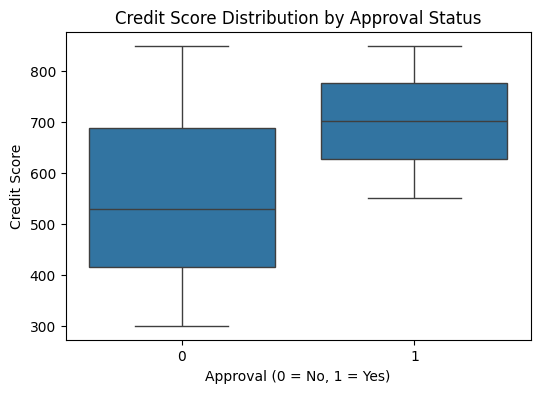

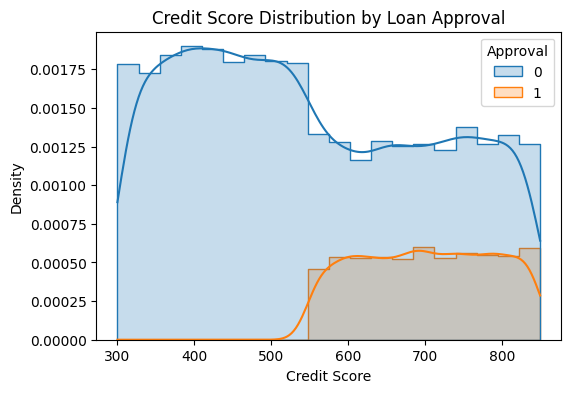

In [81]:
# Boxplot: approval vs not approval
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Approval", y="Credit_Score")
plt.title("Credit Score Distribution by Approval Status")
plt.xlabel("Approval (0 = No, 1 = Yes)")
plt.ylabel("Credit Score")
plt.show()

# Histogram with hue
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Credit_Score", hue="Approval", bins=20, kde=True, element="step", stat="density")
plt.title("Credit Score Distribution by Loan Approval")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.show()


## Boxplot (income distribution by approval)

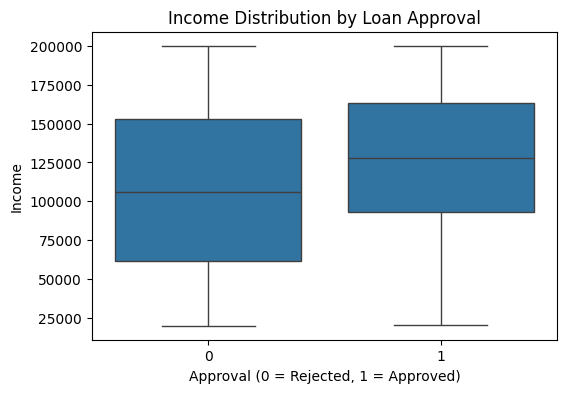

In [122]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Approval", y="Income")
plt.title("Income Distribution by Loan Approval")
plt.xlabel("Approval (0 = Rejected, 1 = Approved)")
plt.ylabel("Income")
plt.show()

## Histogram / KDE (separate distributions)

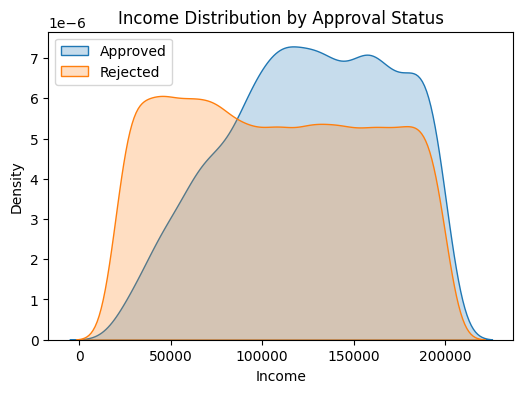

In [123]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df[df['Approval']==1]['Income'], label="Approved", fill=True)
sns.kdeplot(data=df[df['Approval']==0]['Income'], label="Rejected", fill=True)
plt.title("Income Distribution by Approval Status")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.show()

## Mean income by approval (barplot)

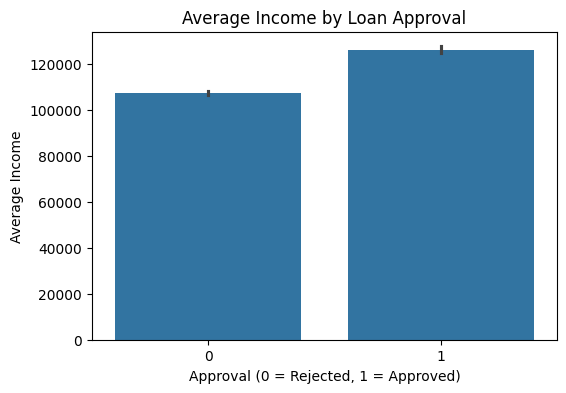

In [124]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Approval", y="Income", estimator="mean")
plt.title("Average Income by Loan Approval")
plt.xlabel("Approval (0 = Rejected, 1 = Approved)")
plt.ylabel("Average Income")
plt.show()

## Countplot — Approval distribution per Text

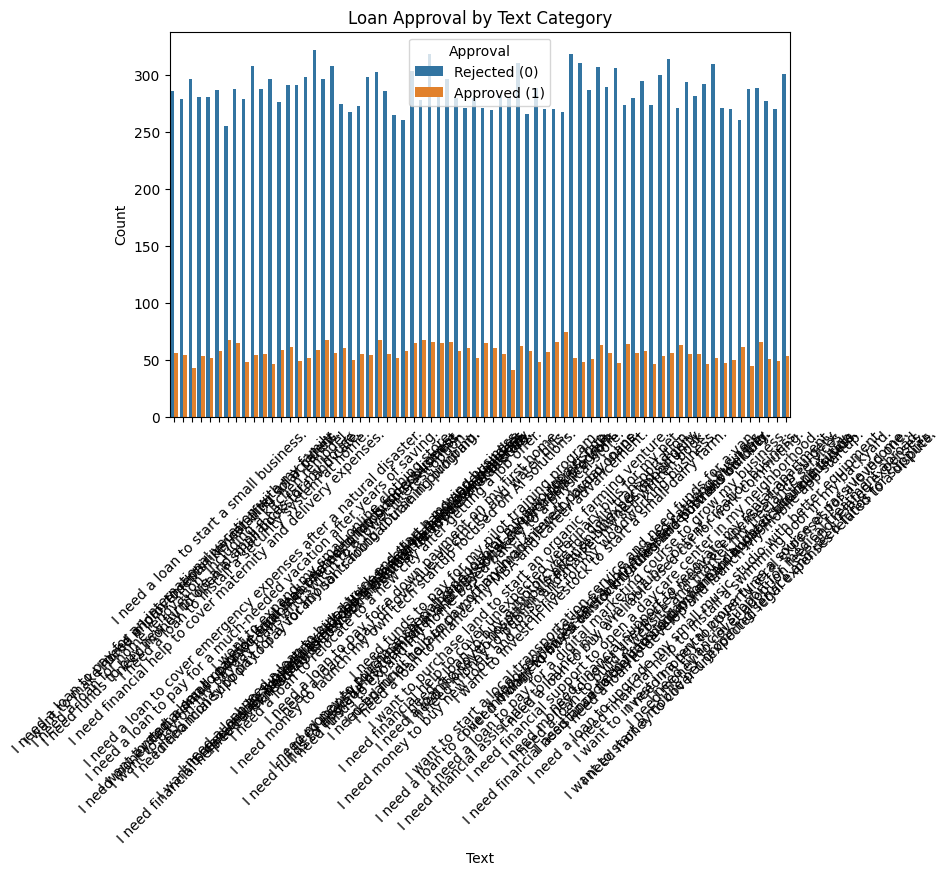

In [125]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Text", hue="Approval")
plt.title("Loan Approval by Text Category")
plt.xlabel("Text")
plt.ylabel("Count")
plt.legend(title="Approval", labels=["Rejected (0)", "Approved (1)"])
plt.xticks(rotation=45)  # agar categories lambi hain
plt.show()


## Percentage (Approval Rate by Text)

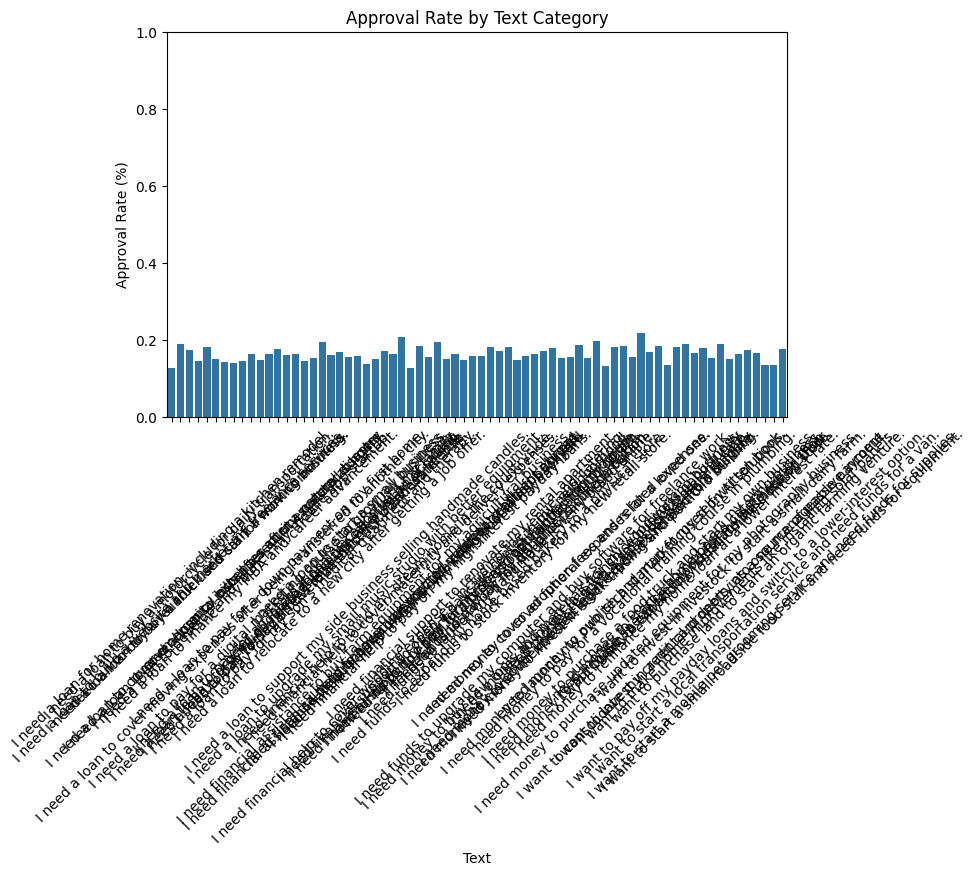

In [86]:
approval_rate_text = df.groupby("Text")["Approval"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=approval_rate_text, x="Text", y="Approval")
plt.title("Approval Rate by Text Category")
plt.ylabel("Approval Rate (%)")
plt.ylim(0,1)  # 0 to 100% scale
plt.xticks(rotation=45)
plt.show()


In [87]:
approval_rate_text = df.groupby("Text")["Approval"].mean().reset_index()
approval_rate_text["Approval"] = approval_rate_text["Approval"] * 100  # convert to %
print(approval_rate_text)


                                                 Text   Approval
0   I need a loan for home renovation, including a...  12.647059
1   I need a loan to build a website and market my...  18.862275
2   I need a loan to buy a motorcycle for daily tr...  17.431193
3   I need a loan to buy a reliable used car for w...  14.375000
4   I need a loan to buy a truck and start a movin...  18.108108
..                                                ...        ...
65  I want to pay off my payday loans and switch t...  17.329545
66  I want to purchase land to start an organic fa...  16.621984
67  I want to start a local transportation service...  13.370474
68  I want to start a mobile pet grooming service ...  13.513514
69  I want to start a small roadside food stall an...  17.611940

[70 rows x 2 columns]


In [88]:
approval_rate_text["Approval"] = approval_rate_text["Approval"].round(2)
print(approval_rate_text)

                                                 Text  Approval
0   I need a loan for home renovation, including a...     12.65
1   I need a loan to build a website and market my...     18.86
2   I need a loan to buy a motorcycle for daily tr...     17.43
3   I need a loan to buy a reliable used car for w...     14.37
4   I need a loan to buy a truck and start a movin...     18.11
..                                                ...       ...
65  I want to pay off my payday loans and switch t...     17.33
66  I want to purchase land to start an organic fa...     16.62
67  I want to start a local transportation service...     13.37
68  I want to start a mobile pet grooming service ...     13.51
69  I want to start a small roadside food stall an...     17.61

[70 rows x 2 columns]


In [116]:
# Target column (0 = Regected, 1 = Approved)
df = df.dropna(subset=['Approval']).reset_index(drop=True)
df['target'] = df['Approval'].astype(int)

## 4. Features

In [126]:
numeric_features = [c for c in ['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio'] if c in df.columns]
categorical_features = [c for c in ['Employment_Status'] if c in df.columns]
text_feature = 'Text' if 'Text' in df.columns else None

In [127]:
# Ensure numeric columns are numeric
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [128]:
# Final features
use_cols = numeric_features + categorical_features + ([text_feature] if text_feature else [])
X = df[use_cols].copy()
y = df['target']


In [129]:
# Train/Test Split (Stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

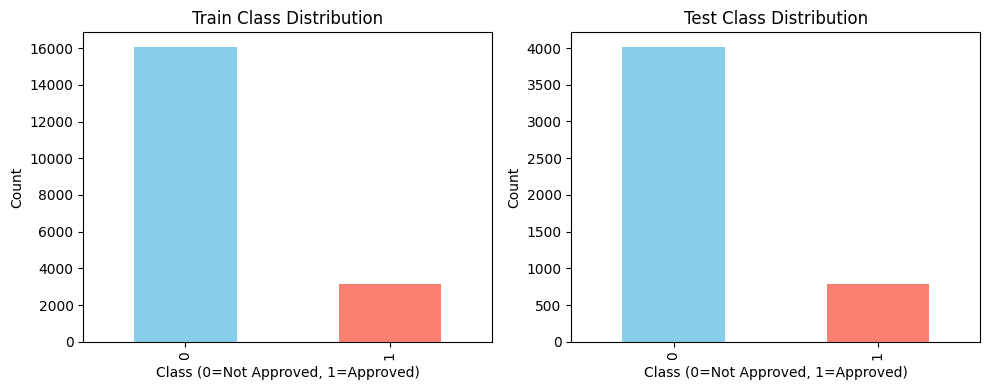

In [140]:
# Count values
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Bar plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Train distribution
train_counts.plot(kind='bar', ax=ax[0], color=['skyblue', 'salmon'])
ax[0].set_title("Train Class Distribution")
ax[0].set_xlabel("Class (0=Not Approved, 1=Approved)")
ax[0].set_ylabel("Count")

# Test distribution
test_counts.plot(kind='bar', ax=ax[1], color=['skyblue', 'salmon'])
ax[1].set_title("Test Class Distribution")
ax[1].set_xlabel("Class (0=Not Approved, 1=Approved)")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## 5. Transformers

In [130]:
if text_feature:
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('svd', SafeSVD(n_components=50))
    ])
else:
    text_transformer = 'drop'

In [131]:
# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('txt', text_transformer, text_feature)
])

## 6. Baseline Logistic Regression

In [133]:
baseline_lr = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42))
])

baseline_lr.fit(X_train, y_train)
y_pred_base = baseline_lr.predict(X_test)
y_proba_base = baseline_lr.predict_proba(X_test)[:, 1]

In [134]:
print("\n--- Baseline Logistic Regression ---")
print(classification_report(y_test, y_pred_base, digits=4))
print("Average precision (PR AUC):", average_precision_score(y_test, y_proba_base))


--- Baseline Logistic Regression ---
              precision    recall  f1-score   support

           0     0.9898    0.8911    0.9378      4013
           1     0.6318    0.9530    0.7599       787

    accuracy                         0.9012      4800
   macro avg     0.8108    0.9220    0.8489      4800
weighted avg     0.9311    0.9012    0.9087      4800

Average precision (PR AUC): 0.8729403306884124


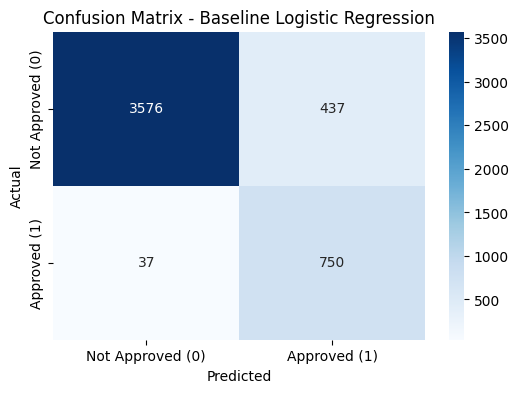

In [141]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

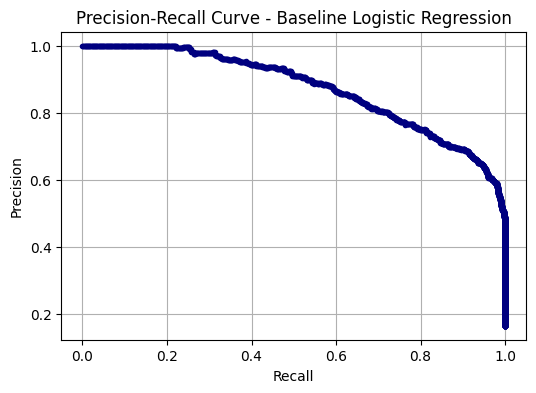

In [142]:
# --- Precision-Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_base)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', color='navy')
plt.title("Precision-Recall Curve - Baseline Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

## 7. Logistic Regression + SMOTE

In [135]:
smote_lr = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=42))
])

smote_lr.fit(X_train, y_train)
y_pred_smote = smote_lr.predict(X_test)
y_proba_smote = smote_lr.predict_proba(X_test)[:, 1]

In [136]:
print("\n--- Logistic Regression + SMOTE ---")
print(classification_report(y_test, y_pred_smote, digits=4))
print("Average precision (PR AUC):", average_precision_score(y_test, y_proba_smote))


--- Logistic Regression + SMOTE ---
              precision    recall  f1-score   support

           0     0.9882    0.8976    0.9407      4013
           1     0.6442    0.9454    0.7662       787

    accuracy                         0.9054      4800
   macro avg     0.8162    0.9215    0.8535      4800
weighted avg     0.9318    0.9054    0.9121      4800

Average precision (PR AUC): 0.8737832531280476


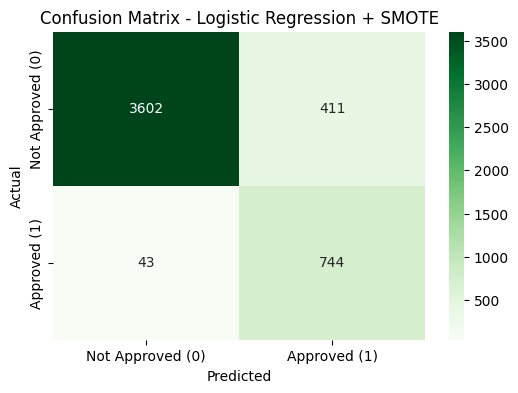

In [143]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.title("Confusion Matrix - Logistic Regression + SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

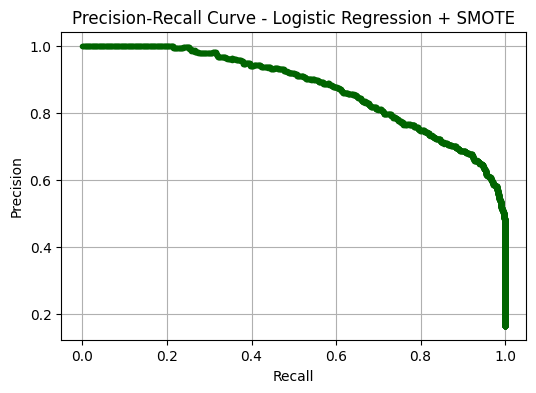

In [144]:
# --- Precision-Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', color='darkgreen')
plt.title("Precision-Recall Curve - Logistic Regression + SMOTE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

## 8. Decision Tree + SMOTE

In [137]:
tree_sm = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

tree_sm.fit(X_train, y_train)
y_pred_tree = tree_sm.predict(X_test)

In [138]:
print("\n--- Decision Tree + SMOTE ---")
print(classification_report(y_test, y_pred_tree, digits=4))


--- Decision Tree + SMOTE ---
              precision    recall  f1-score   support

           0     0.9973    0.9958    0.9965      4013
           1     0.9786    0.9860    0.9823       787

    accuracy                         0.9942      4800
   macro avg     0.9879    0.9909    0.9894      4800
weighted avg     0.9942    0.9942    0.9942      4800



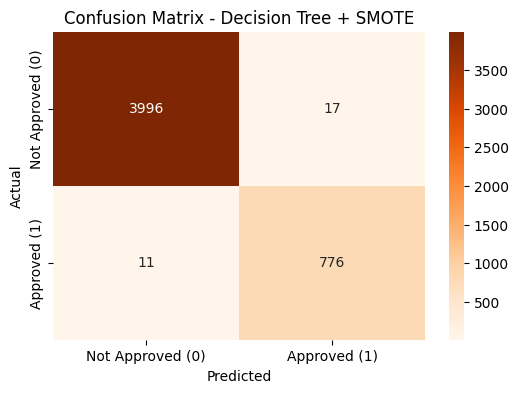

In [145]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.title("Confusion Matrix - Decision Tree + SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

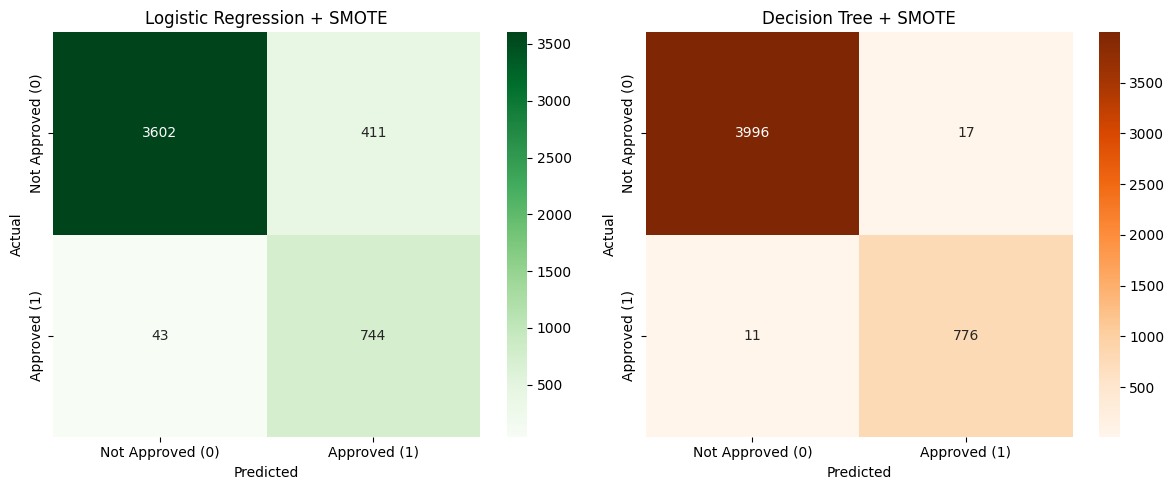

In [146]:
# --- Confusion Matrices ---
cm_lr = confusion_matrix(y_test, y_pred_smote)
cm_tree = confusion_matrix(y_test, y_pred_tree)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'],
            ax=axes[0])
axes[0].set_title("Logistic Regression + SMOTE")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'],
            ax=axes[1])
axes[1].set_title("Decision Tree + SMOTE")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()



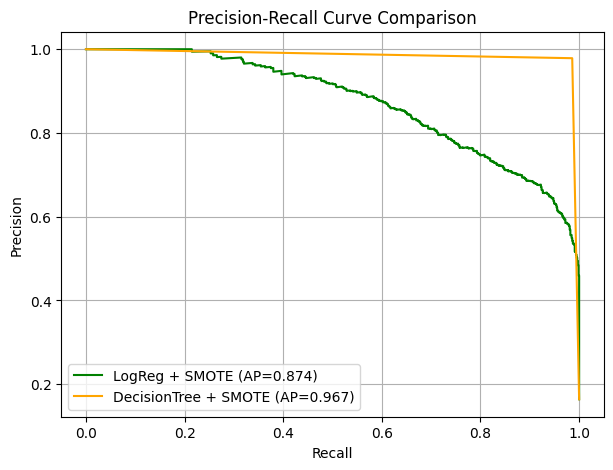

In [147]:
# --- Precision-Recall Curves ---
y_proba_tree = tree_sm.predict_proba(X_test)[:, 1]  # Decision Tree probability

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_smote)
precision_tree, recall_tree, _ = precision_recall_curve(y_test, y_proba_tree)

plt.figure(figsize=(7, 5))
plt.plot(recall_lr, precision_lr, label=f"LogReg + SMOTE (AP={average_precision_score(y_test, y_proba_smote):.3f})", color="green")
plt.plot(recall_tree, precision_tree, label=f"DecisionTree + SMOTE (AP={average_precision_score(y_test, y_proba_tree):.3f})", color="orange")
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()